## GPyTorch for inducing points

Our aim: 
- given a known model (currently GP with various priors)
- and a ground truth
- infer "missing values"


GPyTorch's approach:
- setup very simple model
- 1 single piece of training data to observe
- test_x: set of points 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import gpytorch
from matplotlib import pyplot as plt
from jax import random
import jax.numpy as jnp
import numpy as onp
import numpyro
from numpyro.infer import Predictive

from reusable.geo import load_state_centroids, centroids_to_coords, get_temp_data
numpyro.set_host_device_count(3)


In [4]:
from reusable.kernels import esq_kernel

args = {
    # geographic data
    "state": 36,  # New York
    # ground truth
    "year": 2010,
    "aggr_method": "mean",
    "coord_scaling_factor":  1e5,
    # GP prior configuration
    "gp_kernel": esq_kernel,
    "rng_key": random.PRNGKey(2),
}

state_centroids = load_state_centroids(args["state"])
jnp_coords, coord_means  = centroids_to_coords(state_centroids, args["coord_scaling_factor"])
coords = torch.from_numpy(onp.array(jnp_coords))

args.update(
    {  # so we can use the definition of n to define x
        "x": coords,
        "n": coords.shape[0],
      
       "length_prior_choice": "invgamma",
        "length_prior_arguments": {"concentration": 4.0, "rate": 1.0},
        "variance_prior_choice": "gamma",
        "variance_prior_arguments": {"concentration": 5.25, "rate": 0.5},
        "expcode": "25",
        

       "inducing_fracs": [0.2] # [0.05, 0.10, 0.2, 0.3]

})

rng_key, _ = random.split(random.PRNGKey(4))

from reusable.gp import BuildGP

gp = BuildGP(
    args["gp_kernel"],
    noise=True,
    length_prior_choice=args["length_prior_choice"],
    length_prior_args=args["length_prior_arguments"],
    variance_prior_choice=args["variance_prior_choice"],
    variance_prior_args=args["variance_prior_arguments"],
)


ground_truth_df = get_temp_data(args["state"], args["year"], args["aggr_method"])

ground_truth = ground_truth_df["tmean"].to_numpy()
ground_truth_torch = torch.from_numpy(ground_truth).long()

rng_key_ground_truth = random.PRNGKey(
    10
)  # fixed to generate a "ground truth" GP we will try and infer

rng_key_ground_truth, rng_key_obs = random.split(rng_key_ground_truth, 2)



Mean 10.5 Variance 21.0


In [5]:
from torch.nn import Module as TModule


class InverseGammaPrior(gpytorch.priors.Prior, torch.distributions.TransformedDistribution):
    """Gamma Prior parameterized by concentration and rate

    pdf(x) = beta^alpha / Gamma(alpha) * x^(alpha - 1) * exp(-beta * x)

    where alpha > 0 and beta > 0 are the concentration and rate parameters, respectively.
    """

    def __init__(self, concentration, rate, validate_args=False, transform=None):
        TModule.__init__(self)
        base_dist = torch.distributions.Gamma(concentration, rate)
        torch.distributions.TransformedDistribution.__init__(
            self,
            base_dist,
            torch.distributions.PowerTransform(-base_dist.rate.new_ones(())),
            validate_args=validate_args,
        )
        #_bufferize_attributes(self, ("concentration", "rate"))
        self._transform = transform

    def expand(self, batch_shape):
        batch_shape = torch.Size(batch_shape)
        return InverseGammaPrior(self.concentration.expand(batch_shape), self.rate.expand(batch_shape))

    def __call__(self, *args, **kwargs):
        return super(torch.distributions.TransformedDistribution, self).__call__(*args, **kwargs)


In [6]:
def args_to_prior(choice, args):
    if choice == "invgamma":
        conc = args.get("concentration", 4)
        rate = args.get("rate", 1)
        return InverseGammaPrior(conc, rate)

    elif choice == "lognormal":
        loc = args.get("location", 0.0)
        scale = args.get("scale", 0.1)
        return gpytorch.priors.LogNormalPrior(loc, scale)

    elif choice == "normal":
        loc = args.get("location", 0.0)
        scale = args.get("scale", 15.0)
        return gpytorch.priors.NormalPrior(loc, scale)

    elif choice == "halfnormal":
        scale = args.get("scale", 15.0)
        return gpytorch.priors.HalfNormalPrior(scale)

    elif choice == "gamma":
        conc = args.get("concentration", 4)
        rate = args.get("rate", 1)
        return gpytorch.priors.GammaPrior(conc, rate)

    elif choice == "uniform":
        lower = args.get("lower", 0.01)
        upper = args.get("upper", 0.5)
        return gpytorch.priors.UniformPrior(lower, upper)


# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(lengthscale_prior=args_to_prior(args["length_prior_choice"], args["length_prior_arguments"])),
            outputscale_prior=args_to_prior(args["variance_prior_choice"], args["variance_prior_arguments"]),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    

class StandardApproximateGP(gpytorch.models.ApproximateGP):
    """Approximate GP with standard Varational Strategy + Cholesky variational dist, plus same priors as above"""
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(lengthscale_prior=args_to_prior(args["length_prior_choice"], args["length_prior_arguments"])),
            outputscale_prior=args_to_prior(args["variance_prior_choice"], args["variance_prior_arguments"]),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


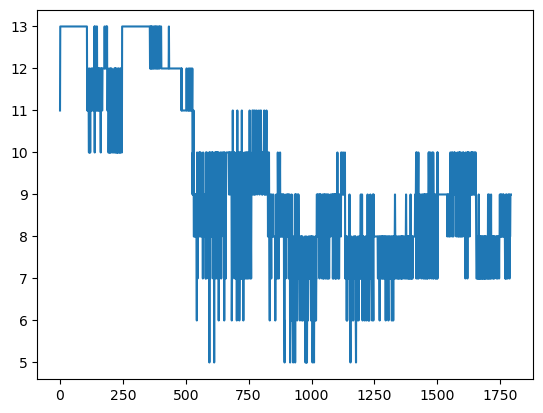

In [7]:
plt.plot(onp.arange(args["n"]), ground_truth_torch)

In [8]:
# Training data is 100 points in [0,1] inclusive regularly spaced

train_x = args["x"]

inducing_points_list = []

for i, frac in enumerate(args["inducing_fracs"]):
    num_ind = int(frac * args["n"])

    
    inducing_points_list.append(torch.randn(num_ind, train_x.size(-1), dtype=train_x.dtype, device=train_x.device))

train_y = ground_truth_torch

    

In [9]:
inducing_points_list[0].shape

torch.Size([358, 2])

In [10]:
def train_approx_model(inducing_points, num_data, training_iter=1000):
    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = StandardApproximateGP(inducing_points)
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer, now need to include GaussianLikelihood parameters by hand
    optimizer =  torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1) 

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=num_data)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if i % 100 ==0:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.base_kernel.lengthscale.item(),
                likelihood.noise.item()
            ))
        optimizer.step()

    return model, likelihood

In [11]:
def evaluate_model(model, likelihood, test_x):
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    # Test points are regularly spaced along [0,1]
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        print(model(test_x).covariance_matrix)
        observed_pred = likelihood(model(test_x))
    with torch.no_grad():
        # Initialize plot

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
    return observed_pred.mean.numpy(), lower.numpy(), upper.numpy()


def plot_evaluations(train_x, train_y, test_x, observed_means, lowers, uppers, max_per_row=2):
    assert len(observed_means) == len(lowers) and len(lowers) == len(uppers)

    num_per_row = min(max_per_row, len(observed_means))
    num_rows = (len(observed_means) + num_per_row -1) // num_per_row


    f, axs = plt.subplots(num_rows, num_per_row, figsize=(num_per_row *10, num_rows * 6))
    
    for i in range(len(observed_means)):
        # Plot training data as black stars
        axs.flat[i].plot(train_x, train_ys[i], 'k*')
        # Plot predictive means as blue line
        axs.flat[i].plot(test_x, observed_means[i], 'b')

        axs.flat[i].plot(test_x, ground_truth, 'r')
        # Shade between the lower and upper confidence bounds
        axs.flat[i].fill_between(test_x, lowers[i], uppers[i], alpha=0.5)
        axs.flat[i].set_ylim([2.5, 15])
        axs.flat[i].legend(['Observed Data', 'Mean', "Ground truth (with noise)", 'Confidence'])
        axs.flat[i].set_title(f"{len(inducing_points_list[i])} inducing points")

In [12]:
means = []
lowers = []
uppers = []
learnt_inducing_points = []

for i in range(len(inducing_points_list)):
    model, likelihood = train_approx_model(inducing_points_list[i], train_y.shape[0])
    learnt_inducing_points.append(model.variational_strategy.inducing_points)
    mean, lower, upper = evaluate_model(model, likelihood, args["x"])
    means.append(mean)
    lowers.append(lower)
    uppers.append(upper)


Iter 1/1000 - Loss: 68.036   lengthscale: 0.693   noise: 0.693
Iter 101/1000 - Loss: 1.462   lengthscale: 1.090   noise: 1.839
Iter 201/1000 - Loss: 1.347   lengthscale: 1.001   noise: 1.610
Iter 301/1000 - Loss: 1.251   lengthscale: 0.939   noise: 1.307
Iter 401/1000 - Loss: 1.141   lengthscale: 0.897   noise: 0.963
Iter 501/1000 - Loss: 1.079   lengthscale: 0.866   noise: 0.638
Iter 601/1000 - Loss: 0.976   lengthscale: 1.180   noise: 0.532
Iter 701/1000 - Loss: 0.967   lengthscale: 0.921   noise: 0.364
Iter 801/1000 - Loss: 0.779   lengthscale: 0.727   noise: 0.275
Iter 901/1000 - Loss: 1.975   lengthscale: 0.706   noise: 0.218
tensor([[ 9.1443e-02, -3.2818e-04,  1.8418e-05,  ..., -1.0073e-04,
         -1.0353e-03, -6.3138e-04],
        [-3.2818e-04,  2.0149e-03,  1.8840e-03,  ...,  1.8343e-05,
         -1.4275e-05, -3.0845e-06],
        [ 1.8358e-05,  1.8830e-03,  2.0783e-03,  ...,  4.9412e-05,
         -5.3033e-05, -8.2105e-06],
        ...,
        [-1.0075e-04,  1.8254e-05,  4.9

In [16]:
learnt_inducing_points[0].detach().numpy().shape

(358, 2)

In [35]:
means

[array([10.301512, 12.989338, 13.040789, ...,  8.398649,  8.482777,
         8.444737], dtype=float32)]

In [36]:
jnp.dstack(coord_means)

Array([[[2472990., 4965505.]]], dtype=float32)

PLotiting
PLotiting
PLotiting
PLotiting


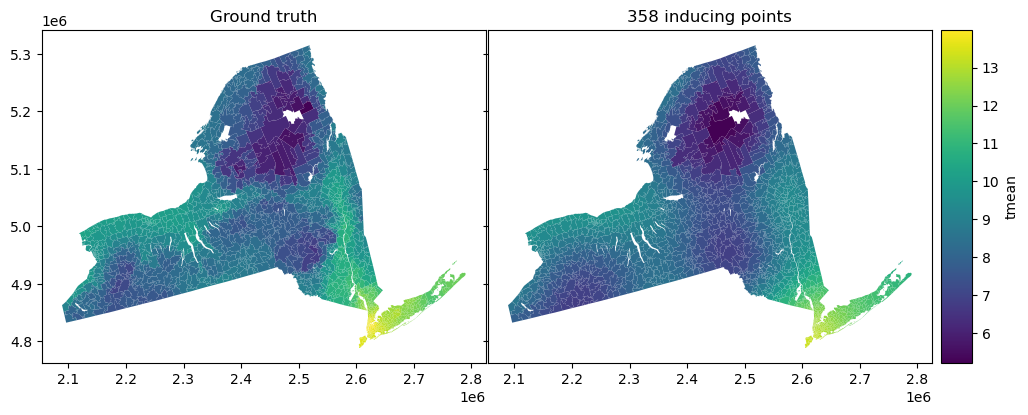

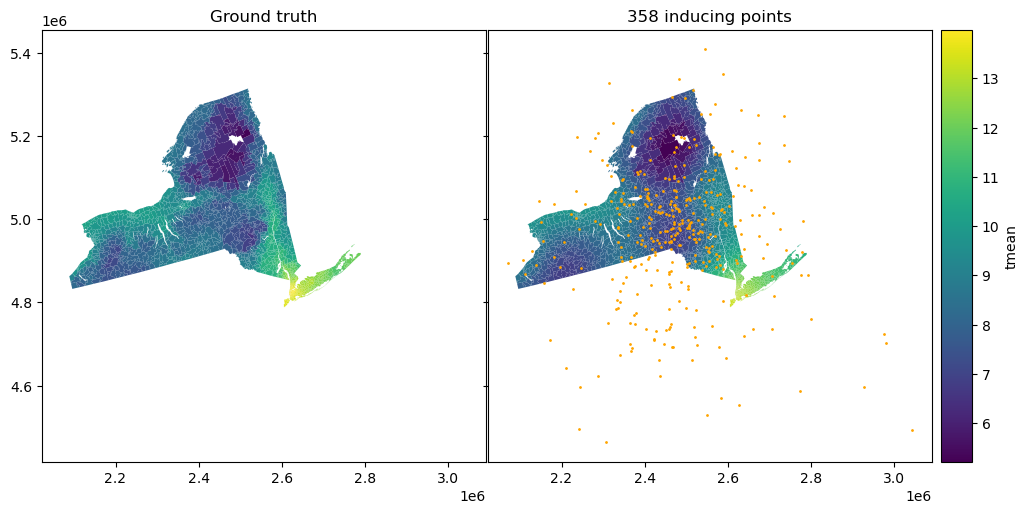

In [37]:
from plotting.ny import plot_multi_on_state

scaled_learnt_inducing_points = [None] + [x.detach().numpy() * args["coord_scaling_factor"] + onp.array(coord_means)  for x in learnt_inducing_points]
plot_multi_on_state(onp.array([ground_truth] + means), 36, "Inference comaprisons", "tmean", ["Ground truth"] + [f"{len(x)} inducing points" for x in inducing_points_list], num_in_row=5)


plot_multi_on_state(onp.array([ground_truth] + means), 36, "Inference comaprisons", "tmean", ["Ground truth"] + [f"{len(x)} inducing points" for x in inducing_points_list], num_in_row=5, points=scaled_learnt_inducing_points)

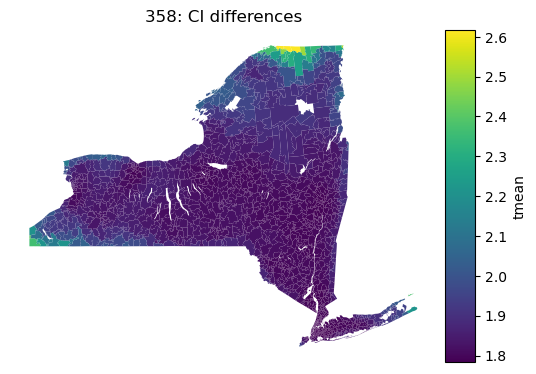

In [14]:

plot_multi_on_state(onp.array([u - l for u,l in zip(uppers, lowers)]), 36, "CI comparisons", "tmean",  [f"{len(x)}: CI differences" for x in inducing_points_list])